In [2]:
drop_val = 0.6

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Importing required libraries
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, GRU, Bidirectional, RNN
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re
import string
from sklearn.metrics import classification_report
from sklearn.svm import SVC

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# ETL

In [5]:
#Loading the dataset
data = pd.read_csv('/content/drive/MyDrive/NLP/Assignment 2/Sarcasm Dataset.csv')

# df = data.copy()

In [6]:
# setting type as string
data['tweet'] = data['tweet'].astype(str)
# converting to lower case
data['tweet'] = data['tweet'].apply(lambda x: x.lower())
# Removing non-alpabetic characters
data['tweet'] = data['tweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

data['tweet'] = data['tweet'].apply((lambda x: re.sub('\r','',x)))

print('sarcastic: ', data[data['sarcastic'] == 1].size)
print('not sarcastic:', data[data['sarcastic'] == 0].size)

for idx,row in data.iterrows():
    row['tweet'] = row['tweet'].replace('rt',' ')
data['tweet'].head()

sarcastic:  7803
not sarcastic: 23409


0    the only thing i got from college is a caffein...
1    i love it when professors draw a big question ...
2    remember the hundred emails from companies whe...
3    today my poppop told me i was not forced to go...
4    volphancarol littlewhitty mysticalmanatee i di...
Name: tweet, dtype: object

In [7]:
# vocabulary size
sentences = [sublist.split() for sublist in data['tweet'].astype(str).values]
words = set([item for sublist in sentences for item in sublist])
num_words = len(words)
num_words

10760

In [8]:
# # tokenization and padding
# max_fatures = num_words
tokenizer = Tokenizer(num_words=num_words, split=' ')
tokenizer.fit_on_texts(data['tweet'].values)
X1 = tokenizer.texts_to_sequences(data['tweet'].values)
X = pad_sequences(X1)
num_words = len(tokenizer.word_index.items())
print('shape of X', X.shape)
# num_words


shape of X (3468, 61)


In [9]:
Y = pd.get_dummies(data['sarcastic']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2323, 61) (2323, 2)
(1145, 61) (1145, 2)


In [11]:
X[341,60]

36

# Vanilla Weights

### LSTM

In [ ]:
embed_dim = 256
lstm_out = 196

# Create model
model = Sequential()
# model.add(Embedding(num_words,200,weights=[embedding_matrix],trainable=False))
model.add(Embedding(num_words, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(drop_val))
model.add(LSTM(128, dropout=drop_val, recurrent_dropout=drop_val, activation='relu', input_shape=(360,1), return_sequences=True))
model.add(LSTM(64, dropout=drop_val, recurrent_dropout=drop_val))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 63, 256)           2792960   
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 63, 256)          0         
 lDropout1D)                                                     
                                                                 
 lstm_8 (LSTM)               (None, 63, 128)           197120    
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 3,039,618
Trainable params: 3,039,618
Non-trainable params: 0
____________________________________________

In [ ]:
batch_size = 32
history = model.fit(X_train, Y_train, epochs = 100, batch_size=batch_size, validation_data=(X_test, Y_test))

Epoch 1/100
73/73 [==============================] - 28s 314ms/step - loss: 0.5663 - accuracy: 0.7538 - val_loss: 0.5813 - val_accuracy: 0.7336
Epoch 2/100
73/73 [==============================] - 22s 308ms/step - loss: 0.5511 - accuracy: 0.7581 - val_loss: 0.5928 - val_accuracy: 0.7336
Epoch 3/100
73/73 [==============================] - 22s 306ms/step - loss: 0.5279 - accuracy: 0.7581 - val_loss: 0.5836 - val_accuracy: 0.7336
Epoch 4/100
73/73 [==============================] - 22s 302ms/step - loss: 0.4749 - accuracy: 0.7714 - val_loss: 0.6203 - val_accuracy: 0.7100
Epoch 5/100
73/73 [==============================] - 22s 307ms/step - loss: 0.3463 - accuracy: 0.8545 - val_loss: 0.6797 - val_accuracy: 0.7170
Epoch 6/100
73/73 [==============================] - 22s 304ms/step - loss: 0.2266 - accuracy: 0.9096 - val_loss: 0.7295 - val_accuracy: 0.7092
Epoch 7/100
73/73 [==============================] - 22s 304ms/step - loss: 0.1407 - accuracy: 0.9471 - val_loss: 0.8820 - val_accuracy:

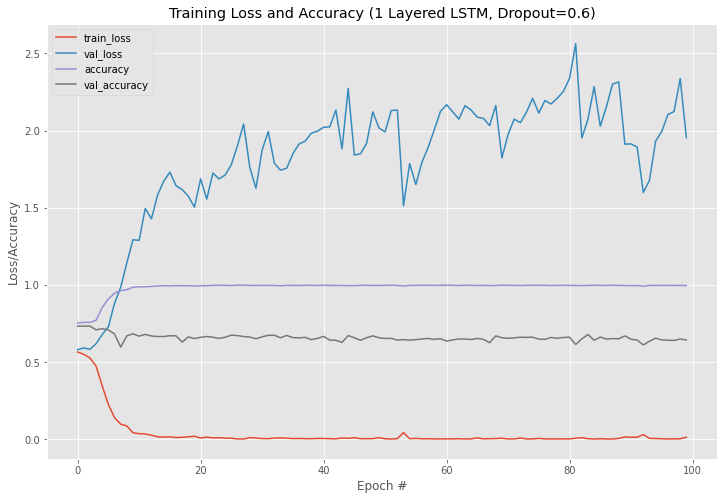

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
plt.rcParams["figure.figsize"] = (12,8)
N = np.arange(0, 100)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.plot(N, history.history['accuracy'], label="accuracy")
plt.plot(N, history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy (1 Layered LSTM, Dropout=0.6)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [ ]:
y_pred = model.predict(X_test)
idx = np.argmax(y_pred, axis=-1)
a = np.zeros( y_pred.shape )
a[ np.arange(y_pred.shape[0]), idx] = 1
# pd.DataFrame(a).head()
a = a.astype(np.uint8)
print('Y_test', Y_test.dtype,  Y_test.shape)
print('a', a.dtype,  a.shape)

Y_test uint8 (1145, 2)
a uint8 (1145, 2)


In [ ]:
print(classification_report(Y_test, a, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       840
           1       0.32      0.31      0.32       305

   micro avg       0.64      0.64      0.64      1145
   macro avg       0.54      0.54      0.54      1145
weighted avg       0.64      0.64      0.64      1145
 samples avg       0.64      0.64      0.64      1145



###SVM

In [24]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y[:,0], test_size = 0.33, random_state = 42)

In [25]:
# instantiate classifier with default hyperparameters
svc=SVC() 
# fit classifier to training set
svc.fit(Xtrain,Ytrain)
# make predictions on test set
y_pred=svc.predict(Xtest)
y_pred

array([0, 1, 0, ..., 1, 1, 1], dtype=uint8)

In [26]:
Ytest

array([1, 0, 0, ..., 0, 1, 0], dtype=uint8)

In [27]:
print(classification_report(Ytest, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.67      0.28      0.39       305
           1       0.78      0.95      0.86       840

    accuracy                           0.77      1145
   macro avg       0.73      0.61      0.63      1145
weighted avg       0.75      0.77      0.74      1145



# Glove

In [13]:
# Load Glove tweet embeddings
embeddings_index = dict()
f = open('/content/drive/MyDrive/NLP/Assignment 2/Embeddings/glove.twitter.27B.200d.txt',encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193514 word vectors.


In [14]:
#Creating embedding matrix
embedding_matrix = np.zeros((num_words, 200))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### LSTM

In [ ]:
# embed_dim = 128
lstm_out = 196

# Create model
model1 = Sequential()
model1.add(Embedding(num_words,200,weights=[embedding_matrix],trainable=False))
# model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model1.add(SpatialDropout1D(drop_val))
model1.add(LSTM(128, dropout=drop_val, recurrent_dropout=drop_val, activation='relu', input_shape=(360,1), return_sequences=True))
model1.add(LSTM(64, dropout=drop_val, recurrent_dropout=drop_val))
model1.add(Dense(2,activation='softmax'))
model1.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model1.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 200)         2182000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, None, 200)        0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, None, 128)         168448    
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 2,399,986
Trainable params: 217,986
Non-trainable params: 2,182,000
______________________________________

In [ ]:
batch_size = 32
history1 = model1.fit(X_train, Y_train, epochs = 100, batch_size=batch_size, validation_data=(X_test, Y_test))

Epoch 1/100
73/73 [==============================] - 22s 243ms/step - loss: 0.5737 - accuracy: 0.7520 - val_loss: 0.5823 - val_accuracy: 0.7336
Epoch 2/100
73/73 [==============================] - 17s 237ms/step - loss: 0.5624 - accuracy: 0.7581 - val_loss: 0.5791 - val_accuracy: 0.7336
Epoch 3/100
73/73 [==============================] - 17s 235ms/step - loss: 0.5646 - accuracy: 0.7581 - val_loss: 0.5984 - val_accuracy: 0.7336
Epoch 4/100
73/73 [==============================] - 17s 239ms/step - loss: 0.5563 - accuracy: 0.7581 - val_loss: 0.5782 - val_accuracy: 0.7336
Epoch 5/100
73/73 [==============================] - 17s 239ms/step - loss: 0.5544 - accuracy: 0.7581 - val_loss: 0.5766 - val_accuracy: 0.7336
Epoch 6/100
73/73 [==============================] - 17s 237ms/step - loss: 0.5576 - accuracy: 0.7581 - val_loss: 0.5764 - val_accuracy: 0.7336
Epoch 7/100
73/73 [==============================] - 17s 237ms/step - loss: 0.5504 - accuracy: 0.7581 - val_loss: 0.5782 - val_accuracy:

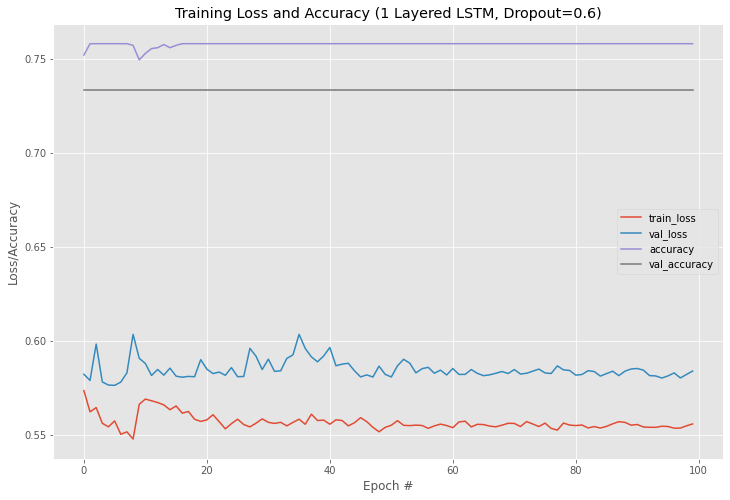

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
plt.rcParams["figure.figsize"] = (12,8)
N = np.arange(0, 100)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history1.history["loss"], label="train_loss")
plt.plot(N, history1.history["val_loss"], label="val_loss")
plt.plot(N, history1.history['accuracy'], label="accuracy")
plt.plot(N, history1.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy (1 Layered LSTM, Dropout=0.6)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [ ]:
y_pred = model.predict(X_test)
idx = np.argmax(y_pred, axis=-1)
a = np.zeros( y_pred.shape )
a[ np.arange(y_pred.shape[0]), idx] = 1
# pd.DataFrame(a).head()
a = a.astype(np.uint8)
print('Y_test', Y_test.dtype,  Y_test.shape)
print('a', a.dtype,  a.shape)

print(classification_report(Y_test, a, labels=[0,1]))

Y_test uint8 (1145, 2)
a uint8 (1145, 2)


              precision    recall  f1-score   support

           0       0.73      1.00      0.85       840
           1       0.00      0.00      0.00       305

   micro avg       0.73      0.73      0.73      1145
   macro avg       0.37      0.50      0.42      1145
weighted avg       0.54      0.73      0.62      1145
 samples avg       0.73      0.73      0.73      1145



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###SVM

In [15]:
embedd_dim = 200

In [16]:
sum = np.zeros((len(X1), embedd_dim))
i = 0

for line in X1:
  j = 0
  for word in line:
    sum[i,:] += embedding_matrix[word]
    j+=1
  sum[i,:] = sum[i,:]/j
  i+=1

sum.shape

In [18]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(sum,Y[:,0], test_size = 0.33, random_state = 42)

In [19]:
# instantiate classifier with default hyperparameters
svc=SVC() 
# fit classifier to training set
svc.fit(Xtrain,Ytrain)
# make predictions on test set
y_pred=svc.predict(Xtest)
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [22]:
Ytest

array([1, 0, 0, ..., 0, 1, 0], dtype=uint8)

In [23]:
print(classification_report(Ytest, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       305
           1       0.73      1.00      0.85       840

    accuracy                           0.73      1145
   macro avg       0.37      0.50      0.42      1145
weighted avg       0.54      0.73      0.62      1145



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# FastText

In [48]:
embeddings_index = dict()
f = open('/content/drive/MyDrive/NLP/Assignment 2/Embeddings/fast_wiki-news-300d-1M-subword.vec',encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 999995 word vectors.


In [49]:
#Creating embedding matrix
embedding_matrix = np.zeros((num_words, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### LSTM

In [ ]:
# embed_dim = 128
lstm_out = 196

# Create model
model2 = Sequential()
model2.add(Embedding(num_words,300,weights=[embedding_matrix],trainable=False))
# model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model2.add(SpatialDropout1D(drop_val))
model2.add(LSTM(128, dropout=drop_val, recurrent_dropout=drop_val, activation='relu', input_shape=(360,1), return_sequences=True))
model2.add(LSTM(64, dropout=drop_val, recurrent_dropout=drop_val))
model2.add(Dense(2,activation='softmax'))
model2.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model2.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 300)         3273000   
                                                                 
 spatial_dropout1d_6 (Spatia  (None, None, 300)        0         
 lDropout1D)                                                     
                                                                 
 lstm_10 (LSTM)              (None, None, 128)         219648    
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 2)                 130       
                                                                 
Total params: 3,542,186
Trainable params: 269,186
Non-trainable params: 3,273,000
______________________________________

In [ ]:
batch_size = 32
history2 = model2.fit(X_train, Y_train, epochs = 100, batch_size=batch_size, validation_data=(X_test, Y_test))

Epoch 1/100
73/73 [==============================] - 25s 274ms/step - loss: 0.5764 - accuracy: 0.7490 - val_loss: 0.5857 - val_accuracy: 0.7336
Epoch 2/100
73/73 [==============================] - 19s 264ms/step - loss: 0.5580 - accuracy: 0.7581 - val_loss: 0.5817 - val_accuracy: 0.7336
Epoch 3/100
73/73 [==============================] - 19s 266ms/step - loss: 0.5577 - accuracy: 0.7581 - val_loss: 0.5833 - val_accuracy: 0.7336
Epoch 4/100
73/73 [==============================] - 19s 265ms/step - loss: 0.5575 - accuracy: 0.7581 - val_loss: 0.5799 - val_accuracy: 0.7336
Epoch 5/100
73/73 [==============================] - 19s 263ms/step - loss: 0.5554 - accuracy: 0.7581 - val_loss: 0.5877 - val_accuracy: 0.7336
Epoch 6/100
73/73 [==============================] - 20s 268ms/step - loss: 0.5544 - accuracy: 0.7581 - val_loss: 0.5832 - val_accuracy: 0.7336
Epoch 7/100
73/73 [==============================] - 19s 266ms/step - loss: 0.5528 - accuracy: 0.7581 - val_loss: 0.5789 - val_accuracy:

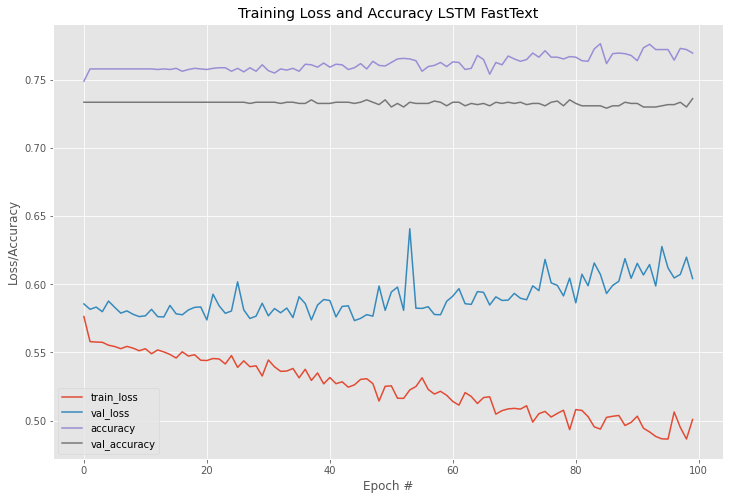

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
plt.rcParams["figure.figsize"] = (12,8)
N = np.arange(0, 100)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history2.history["loss"], label="train_loss")
plt.plot(N, history2.history["val_loss"], label="val_loss")
plt.plot(N, history2.history['accuracy'], label="accuracy")
plt.plot(N, history2.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy LSTM FastText")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [ ]:
y_pred = model2.predict(X_test)
idx = np.argmax(y_pred, axis=-1)
a = np.zeros( y_pred.shape )
a[ np.arange(y_pred.shape[0]), idx] = 1
# pd.DataFrame(a).head()
a = a.astype(np.uint8)
print('Y_test', Y_test.dtype,  Y_test.shape)
print('a', a.dtype,  a.shape)

print(classification_report(Y_test, a, labels=[0,1]))

Y_test uint8 (1145, 2)
a uint8 (1145, 2)
              precision    recall  f1-score   support

           0       0.74      0.99      0.85       840
           1       0.60      0.03      0.06       305

   micro avg       0.74      0.74      0.74      1145
   macro avg       0.67      0.51      0.45      1145
weighted avg       0.70      0.74      0.64      1145
 samples avg       0.74      0.74      0.74      1145



###SVM

In [50]:
embedd_dim = 300

In [52]:
sum = np.zeros((len(X1), embedd_dim), dtype=float)
i = 0

for line in X1:
  j = 0
  for word in line:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      sum[i,:] += embedding_vector.astype(float)
      j+=1
  if j>0:
    sum[i,:] = sum[i,:]/j
  i+=1
sum

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [53]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(sum,Y[:,0], test_size = 0.33, random_state = 42)

In [54]:
# instantiate classifier with default hyperparameters
svc=SVC() 
# fit classifier to training set
svc.fit(Xtrain,Ytrain)
# make predictions on test set
y_pred=svc.predict(Xtest)
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [55]:
Ytest

array([1, 0, 0, ..., 0, 1, 0], dtype=uint8)

In [56]:
print(classification_report(Ytest, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       305
           1       0.73      1.00      0.85       840

    accuracy                           0.73      1145
   macro avg       0.37      0.50      0.42      1145
weighted avg       0.54      0.73      0.62      1145



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Word2vec

In [59]:
import gensim.models.keyedvectors as word2vec
embed_map = word2vec.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/NLP/Assignment 2/Embeddings/GoogleNews-vectors-negative300.bin',binary=True)

In [63]:
# my_dict = dict({})
# for idx, key in enumerate(embed_map.wv.vocab):
#     my_dict[key.lower()] = embed_map.wv[key]
#     # Or my_dict[key] = model.wv.get_vector(key)
    # Or my_dict[key] = model.wv.word_vec(key, use_norm=False)
embed_map

In [68]:
#Creating embedding matrix
def get(model, word):
  try:
    return embed_map.wv[word]
  except:
    return None

embedding_matrix = np.zeros((len(tokenizer.word_index.items()), 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = get(embed_map.wv, word) # my_dict[word]#embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i-1] = embedding_vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


###SVM

In [69]:
embedd_dim = 300


In [70]:
sum = np.zeros((len(X1), embedd_dim), dtype=float)
i = 0

for line in X1:
  j = 0
  for word in line:
    embedding_vector = get(embed_map.wv, word) 
    if embedding_vector is not None:
      sum[i,:] += embedding_vector.astype(float)
      j+=1
  if j>0:
    sum[i,:] = sum[i,:]/j
  i+=1
sum

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [71]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(sum,Y[:,0], test_size = 0.33, random_state = 42)

In [72]:
# instantiate classifier with default hyperparameters
svc=SVC() 
# fit classifier to training set
svc.fit(Xtrain,Ytrain)
# make predictions on test set
y_pred=svc.predict(Xtest)
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [73]:
Ytest

array([1, 0, 0, ..., 0, 1, 0], dtype=uint8)

In [74]:
print(classification_report(Ytest, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       305
           1       0.73      1.00      0.85       840

    accuracy                           0.73      1145
   macro avg       0.37      0.50      0.42      1145
weighted avg       0.54      0.73      0.62      1145



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [75]:
from sklearn.neural_network import MLPClassifier
# instantiate classifier with default hyperparameters
mlp=MLPClassifier() 
# fit classifier to training set
mlp.fit(Xtrain,Ytrain)
# make predictions on test set
y_pred=mlp.predict(Xtest)
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [76]:
print(classification_report(Ytest, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       305
           1       0.73      1.00      0.85       840

    accuracy                           0.73      1145
   macro avg       0.37      0.50      0.42      1145
weighted avg       0.54      0.73      0.62      1145



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### LSTM

In [77]:
# embed_dim = 128
lstm_out = 196

# Create model
model3 = Sequential()
model3.add(Embedding(num_words,300,weights=[embedding_matrix],trainable=False))
# model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model3.add(SpatialDropout1D(drop_val))
model3.add(LSTM(128, dropout=drop_val, recurrent_dropout=drop_val, activation='relu', input_shape=(360,1), return_sequences=True))
model3.add(LSTM(64, dropout=drop_val, recurrent_dropout=drop_val))
model3.add(Dense(2,activation='softmax'))
model3.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model3.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         3230700   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, None, 300)        0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, None, 128)         219648    
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 3,499,886
Trainable params: 269,186
Non-trainable params: 3,230,700
______________________________________

In [79]:
batch_size = 32
history3 = model3.fit(X_train, Y_train, epochs = 100, batch_size=batch_size, validation_data=(X_test, Y_test))

Epoch 1/100
73/73 [==============================] - 26s 358ms/step - loss: 0.5575 - accuracy: 0.7581 - val_loss: 0.5824 - val_accuracy: 0.7336
Epoch 2/100
73/73 [==============================] - 25s 347ms/step - loss: 0.5524 - accuracy: 0.7581 - val_loss: 0.5827 - val_accuracy: 0.7336
Epoch 3/100
73/73 [==============================] - 25s 348ms/step - loss: 0.5547 - accuracy: 0.7581 - val_loss: 0.5864 - val_accuracy: 0.7336
Epoch 4/100
73/73 [==============================] - 25s 349ms/step - loss: 0.5496 - accuracy: 0.7581 - val_loss: 0.5872 - val_accuracy: 0.7336
Epoch 5/100
73/73 [==============================] - 25s 346ms/step - loss: 0.5513 - accuracy: 0.7581 - val_loss: 0.5806 - val_accuracy: 0.7336
Epoch 6/100
73/73 [==============================] - 26s 350ms/step - loss: 0.5478 - accuracy: 0.7576 - val_loss: 0.5820 - val_accuracy: 0.7336
Epoch 7/100
73/73 [==============================] - 26s 351ms/step - loss: 0.5489 - accuracy: 0.7581 - val_loss: 0.5845 - val_accuracy:

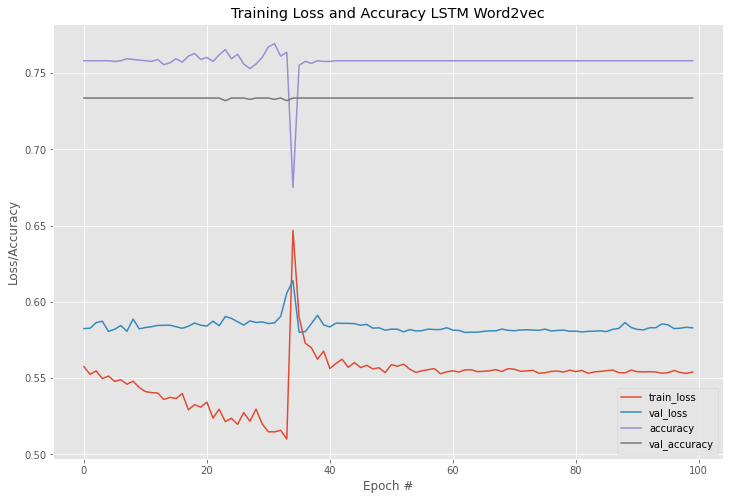

In [80]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
plt.rcParams["figure.figsize"] = (12,8)
N = np.arange(0, 100)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history3.history["loss"], label="train_loss")
plt.plot(N, history3.history["val_loss"], label="val_loss")
plt.plot(N, history3.history['accuracy'], label="accuracy")
plt.plot(N, history3.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy LSTM Word2vec")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [83]:
y_pred = model3.predict(X_test)
# idx = np.argmax(y_pred, axis=-1)
# a = np.zeros( y_pred.shape )
# a[ np.arange(y_pred.shape[0]), idx] = 1
a = y_pred>0.5
# pd.DataFrame(a).head()
a = a.astype(np.uint8)
print('Y_test', Y_test.dtype,  Y_test.shape)
print('a', a.dtype,  a.shape)

print(classification_report(Y_test, a, labels=[0,1]))

Y_test uint8 (1145, 2)
a uint8 (1145, 2)
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       840
           1       0.00      0.00      0.00       305

   micro avg       0.73      0.73      0.73      1145
   macro avg       0.37      0.50      0.42      1145
weighted avg       0.54      0.73      0.62      1145
 samples avg       0.73      0.73      0.73      1145



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###SVM

In [ ]:
embedd_dim = 300

In [ ]:
sum = np.zeros((len(X1), embedd_dim), dtype=float)
i = 0

for line in X1:
  j = 0
  for word in line:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      sum[i,:] += embedding_vector.astype(float)
      j+=1
  if j>0:
    sum[i,:] = sum[i,:]/j
  i+=1
sum

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(sum,Y[:,0], test_size = 0.33, random_state = 42)

In [ ]:
# instantiate classifier with default hyperparameters
svc=SVC() 
# fit classifier to training set
svc.fit(Xtrain,Ytrain)
# make predictions on test set
y_pred=svc.predict(Xtest)
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [ ]:
Ytest

array([1, 0, 0, ..., 0, 1, 0], dtype=uint8)

In [ ]:
print(classification_report(Ytest, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       305
           1       0.73      1.00      0.85       840

    accuracy                           0.73      1145
   macro avg       0.37      0.50      0.42      1145
weighted avg       0.54      0.73      0.62      1145



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Results

### SVM

In [84]:
SVMresults = {
    'metric': ['F-score', 'Accuracy', 'Precision', 'Recall'],
    'Vanilla': [0.74, 0.77, 0.75, 0.77],
    'Word2Vec': [0.62, 0.73, 0.54, 0.73],
    'Glove': [0.62, 0.73, 0.54, 0.73],
    'Fasttext': [0.62, 0.73, 0.54, 0.73]
}
pd.DataFrame(SVMresults).head()

,metric,Vanilla,Word2Vec,Glove,Fasttext
0,F-score,0.74,0.62,0.62,0.62
1,Accuracy,0.77,0.73,0.73,0.73
2,Precision,0.75,0.54,0.54,0.54
3,Recall,0.77,0.73,0.73,0.73


### LSTM

In [85]:
LSTMresults = {
    'metric': ['F-score', 'Accuracy', 'Precision', 'Recall'],
    'Vanilla': [0.64, 0.64, 0.64, 0.64],
    'Word2Vec': [0.62, 0.73, 0.54, 0.73],
    'Glove': [0.62, 0.73, 0.54, 0.73],
    'Fasttext': [0.64, 0.74, 0.7, 0.74]
}
pd.DataFrame(LSTMresults).head()

,metric,Vanilla,Word2Vec,Glove,Fasttext
0,F-score,0.64,0.62,0.62,0.64
1,Accuracy,0.64,0.73,0.73,0.74
2,Precision,0.64,0.54,0.54,0.70
3,Recall,0.64,0.73,0.73,0.74


# 